# Dropout and maxout
In this lab we will explore the methods of [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf), a regularisation method which stochastically drops out activations from the model during training, and [maxout](http://www.jmlr.org/proceedings/papers/v28/goodfellow13.pdf), another non-linear transformation that can be used in multiple layer models. This is based on material covered in the [sixth lecture slides](http://www.inf.ed.ac.uk/teaching/courses/mlp/2018-19/mlp06-enc.pdf).

## Exercise 1: Implementing a dropout layer

During training the forward propagation through a dropout layer produces outputs where a subset of the input dimensions are set to zero ('dropped out'). The dimensions to be dropped out are randomly sampled for each new batch, with each dimension having a probability $p$ of being included and the inclusion (or not) of each dimension independent of all the others. If the inputs to a dropout layer are $D$ dimensional vectors then we can represent the dropout operation by an elementwise multiplication by a $D$ dimensional *binary mask* vector $\boldsymbol{m} = \left[m_1 ~ m_2 ~\dots~ m_D\right]^{\rm T}$ where $m_d \sim \text{Bernoulli}(p) ~~\forall d \in \lbrace 1 \dots D\rbrace$. 

As a first step implement a `random_binary_mask` function in the cell below to generate a binary mask array of a specified shape, where each value in the outputted array is either a one with probablity `prob_1` or zero with probability `1 - prob_1` and all values are sampled independently.

In [1]:
import numpy as np
def random_binary_mask(prob_1, shape, rng):
    """Generates a random binary mask array of a given shape.
    
    Each value in the outputted array should be an indepedently sampled
    binary value i.e in {0, 1} with the probability of each value
    being 1 being equal to `prob_1`.
    
    Args:
        prob_1: Scalar value in [0, 1] specifying probability each
            entry in output array is equal to one.
        shape: Shape of returned mask array.
        rng (RandomState): Seeded random number generator object.
    
    Returns:
        Random binary mask array of specified shape.
    """
    if rng:
        return rng.binomial(1, prob_1,shape)
    else:
        return np.random.binomial(1, prob_1,shape)

Test your `random_binary_mask` function using the cell below (if your implementation is incorrect you will get an `AssertionError` - look at what the assert statement is checking for a clue as to what is wrong).

In [3]:
import numpy as np
test_shapes = [(1, 1000), (10, 10, 10)]
test_probs = [0.1, 0.5, 0.7]
for i in range(10):
    for shape in test_shapes:
        for prob in test_probs:
            output = random_binary_mask(prob, shape, np.random)
            # Check generating correct shape output
            assert output.shape == shape
            # Check all outputs are binary values
            assert np.all((output == 1.) | (output == 0.))
            # Check proportion equal to one plausible
            # This will be noisy so there is a chance this will error
            # even for a correct implementation
            assert np.abs(output.mean() - prob) < 0.1

Given a randomly sampled binary mask $\boldsymbol{m}$, the outputs $\lbrace \boldsymbol{y}^{(b)} \rbrace_{b=1}^B$ of the stochastic forward propagation through a dropout layer given a batch of inputs $\lbrace \boldsymbol{x}^{(b)} \rbrace_{b=1}^B$ can be calculated by simply performing an elementwise multiplication of the inputs with the mask

\begin{equation}
  y^{(b)}_d = m_k x^{(b)}_d \qquad \forall d \in \lbrace 1 \dots D \rbrace
\end{equation}

The corresponding partial derivatives required for implementing back-propagation through a dropout layer are

\begin{equation}
  \frac{\partial y^{(b)}_k}{\partial x^{(b)}_d} = 
  \begin{cases}
      m_k & \quad k = d \\
      0   & \quad k \neq d
  \end{cases}
  \qquad \forall k,\,d \in \lbrace 1 \dots D \rbrace
\end{equation}

As discussed in the lecture slides, when using a model trained with dropout at test time dimensions are no longer stochastically dropped out and instead all activations are deterministically fed forward through the model. So that the expected (mean) outputs of each layer are the same at test and training we scale the forward propagated inputs during testing by $p$ the probability of each dimension being included in the output. If we denote the deterministically forward-propagated batch of outputs of a dropout layer at test time as $\lbrace \boldsymbol{z}^{(b)} \rbrace_{b=1}^B$ then we have

\begin{equation}
  z^{(b)}_d =
  \mathbb{E}\left[ y^{(b)}_d \right] = 
  \sum_{m_d \in \lbrace 0,1 \rbrace} \left( \mathbb{P}\left[\mathrm{m}_d = m_d\right] m_d x^{(b)}_d \right) =
  (p) (1) x^{(b)}_d  + (1-p) (0) x^{(b)}_d =
  p x^{(b)}_d  \qquad \forall d \in \lbrace 1 \dots D \rbrace
\end{equation}

To allow switching between this stochastic training time behaviour and deterministic test time behaviour, a new abstract `StochasticLayer` class has been defined in the `mlp.layers` module. This acts similarly to the layer objects we have already encountered other than adding an extra boolean argument `stochastic` to the `fprop` method interface. When `stochastic = True` (the default) a stochastic forward propagation should be caculated, for dropout this corresponding to $\boldsymbol{x}^{(b)} \to \boldsymbol{y}^{(b)}$ above. When `stochastic = False` a deterministic forward-propagation corresponding to the expected output of the stochastic forward-propagation should be calculated, for dropout this corresponding to $\boldsymbol{x}^{(b)} \to \boldsymbol{z}^{(b)}$ above.

Using the skeleton `DropoutLayer` class definition below, implement the `fprop` and `bprop` methods. You may wish to store the binary mask used in the forward propagation as an attribute of the class for use in back-propagation - it is fine to assume that the `fprop` and `bprop` will always be called in sync.

In [7]:
from mlp.layers import StochasticLayer

class DropoutLayer(StochasticLayer):
    """Layer which stochastically drops input dimensions in its output."""

    def __init__(self, rng=None, incl_prob=0.5):
        """Construct a new dropout layer.
        
        Args:
            rng (RandomState): Seeded random number generator.
            incl_prob: Scalar value in (0, 1] specifying the probability of
                each input dimension being included in the output.
        """
        super(DropoutLayer, self).__init__(rng)
        assert incl_prob > 0. and incl_prob <= 1.
        self.incl_prob = incl_prob

    def fprop(self, inputs, stochastic=True):
        """Forward propagates activations through the layer transformation.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).
            stochastic: Flag allowing different deterministic
                forward-propagation mode in addition to default stochastic
                forward-propagation e.g. for use at test time. If False
                a deterministic forward-propagation transformation
                corresponding to the expected output of the stochastic
                forward-propagation is applied.

        Returns:
            outputs: Array of layer outputs of shape (batch_size, output_dim).
        """
        if stochastic:
            mask = random_binary_mask(self.incl_prob,inputs.shape[1:],rng=self.rng)
            return inputs * mask
        else:
            return inputs * self.incl_prob


    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs. This should correspond to
        default stochastic forward-propagation.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).
            outputs: Array of layer outputs calculated in forward pass of
                shape (batch_size, output_dim).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape (batch_size, output_dim).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, input_dim).
        """
        mask = inputs == outputs
        return grads_wrt_outputs * mask

    def __repr__(self):
        return 'DropoutLayer(incl_prob={0:.1f})'.format(self.incl_prob)

Test your implementation by running the cell below (if your implementation is incorrect you will get an `AssertionError` - look at what the assert statement is checking for a clue as to what is wrong).

In [8]:
seed = 31102016
rng = np.random.RandomState(seed)
test_incl_probs = [0.1, 0.5, 0.7]
input_shape = (5, 10)
for incl_prob in test_incl_probs:
    layer = DropoutLayer(rng, incl_prob)
    inputs = rng.normal(size=input_shape)
    grads_wrt_outputs = rng.normal(size=input_shape)
    for t in range(100):
        outputs = layer.fprop(inputs, stochastic=True)
        # Check outputted array correct shape
        assert outputs.shape == inputs.shape
        # Check all outputs are either equal to inputs or zero
        assert np.all((outputs == inputs) | (outputs == 0))
        grads_wrt_inputs = layer.bprop(inputs, outputs, grads_wrt_outputs)
        # Check back-propagated gradients only non-zero for non-zero outputs
        assert np.all((outputs != 0) == (grads_wrt_inputs != 0))
        assert np.all(grads_wrt_outputs[outputs != 0] == grads_wrt_inputs[outputs != 0])
    det_outputs = layer.fprop(inputs, stochastic=False)
    # Check deterministic fprop outputs are correct shape
    assert det_outputs.shape == inputs.shape
    # Check deterministic fprop outputs scaled correctly
    assert np.allclose(det_outputs, incl_prob * inputs)

### Optional extension

Above we assumed the same dropout mask was applied to each input in a batch, as specified in the lecture slides. In practice sometimes a different mask is sampled for each input. As an extension you could try implementing this per-input form of dropout either by defining a new layer or adding an extra argument to the constructor of the above layer which allows you to switch between the two forms.

## Exercise 2: Training with dropout

Experiment with training models with dropout layers to classify MNIST digits. Code has been provided below as a starting point for setting up the model objects though feel free to use any additional adaptive learning rules or learning rule schedulers you wrote during the coursework instead. You may also wish to change the model architecture to use a larger model with more parameters in which the regularisation provided by dropout is likely to have a more pronounced effect. You will probably also find that models with dropout generally need to be trained over more epochs than those without (can you suggest why this might be?).

You should training with a few different `incl_prob` settings for the dropout layers and try to establish how the values chosen affect the training performance. You may wish to experiment with using a different dropout probability at the input than for the intermediate layers (why?).

You may wish to start reading through and implementing exercise 3 while waiting for training runs to complete.

In [9]:
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider
from mlp.models import MultipleLayerModel
from mlp.layers import ReluLayer, AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.optimisers import Optimiser
import matplotlib.pyplot as plt
%matplotlib inline

# Seed a random number generator
seed = 31102016
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

Epoch 5: 1.4s to complete
    error(train)=4.50e-01, acc(train)=8.63e-01, error(valid)=4.24e-01, acc(valid)=8.70e-01
Epoch 10: 1.8s to complete
    error(train)=3.71e-01, acc(train)=8.87e-01, error(valid)=3.47e-01, acc(valid)=8.98e-01
Epoch 15: 1.8s to complete
    error(train)=3.31e-01, acc(train)=9.01e-01, error(valid)=3.06e-01, acc(valid)=9.11e-01
Epoch 20: 2.0s to complete
    error(train)=3.15e-01, acc(train)=9.08e-01, error(valid)=2.92e-01, acc(valid)=9.14e-01
Epoch 25: 1.5s to complete
    error(train)=3.02e-01, acc(train)=9.09e-01, error(valid)=2.87e-01, acc(valid)=9.11e-01
Epoch 30: 1.5s to complete
    error(train)=2.91e-01, acc(train)=9.11e-01, error(valid)=2.95e-01, acc(valid)=9.15e-01
Epoch 35: 1.5s to complete
    error(train)=2.86e-01, acc(train)=9.13e-01, error(valid)=2.78e-01, acc(valid)=9.18e-01
Epoch 40: 1.5s to complete
    error(train)=2.80e-01, acc(train)=9.14e-01, error(valid)=2.68e-01, acc(valid)=9.21e-01
Epoch 45: 1.5s to complete
    error(train)=2.72e-01, acc

Text(0.5, 0, 'Epoch number')

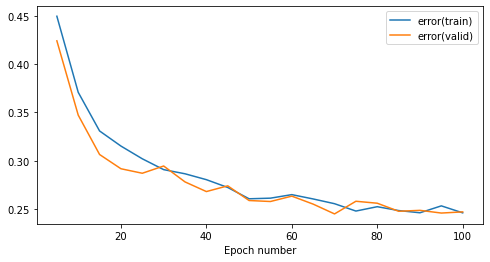

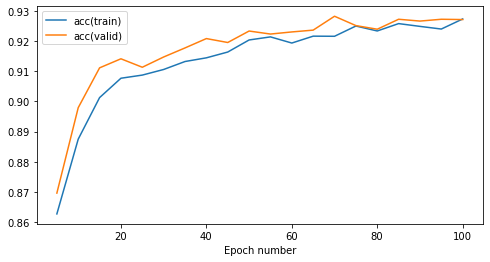

In [10]:
# Probability of input being included in output in dropout layer
incl_prob = 0.5

input_dim, output_dim, hidden_dim = 784, 10, 125

# Use Glorot initialisation scheme for weights and zero biases
weights_init = GlorotUniformInit(rng=rng, gain=2.**0.5)
biases_init = ConstantInit(0.)

# Create three affine layer model with rectified linear non-linearities
# and dropout layers before every affine layer
model = MultipleLayerModel([
    DropoutLayer(rng, incl_prob),
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    DropoutLayer(rng, incl_prob),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError()

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learning_rule = MomentumLearningRule(0.02, 0.9)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

num_epochs = 100
stats_interval = 5

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
              stats[1:, keys[k]], label=k)
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')

## Exercise 3: Implementing maxout

[Maxout](http://www.jmlr.org/proceedings/papers/v28/goodfellow13.pdf) can be considered a generalisation of the rectified linear transformation implemented in the previous lab. 

For a rectified linear (`Relu`) layer the forward propagation corresponds to

\begin{equation}
    y^{(b)}_k = 
    \max\left\lbrace 0,\,x^{(b)}_k \right\rbrace
\end{equation}

i.e. each output corresponds to an pairwise maximum of a constant (0) and the input.

Instead of taking the maximum of the input and a constant, we could instead consider taking the maximum over sets of inputs of a fixed size $s$.

\begin{equation}
    y^{(b)}_k = 
    \max\left\lbrace x^{(b)}_{(k-1)s + 1},\, x^{(b)}_{(k-1)s + 2},\, \dots ,\, x^{(b)}_{ks} \right\rbrace
\end{equation}

If these inputs $x^{(b)}_d$ are themselves the outputs of an affine layer, then this corresponds to taking the maximum of a series of affine functions of the previous layer outputs. Like a rectified linear layer this leads to piecewise linear input-output relationships (which have well-behaved gradients which do not suffer from the saturation problems of logistic sigmoid / hyperbolic tangent transformations) but unlike the rectified linear case we do not end force a portion of the outputs to be zero. 

Experimentally this form of transformation has been found to give good performance, with the name *maxout* chosen because the *out*put is the *max*imum of a set of inputs. Maxout is also commonly used with dropout layers however note they are not directly related - maxout defines a deterministic non-linear transformation which can help improve the representational capacity and trainability of models; dropout defines a stochastic transformation which is mainly aimed at regularising a model to reduce overfitting.

Using layers which take the maximum of fixed sized sets of inputs is also a common technique in models with convolutional layers which we will cover later in the course, with here the layer commonly being termed a *max-pooling* layer (with there being natural generalisation to other choices of reduction functions over pools such as the mean). We will adopt this terminology here for a layer implementing the transformation described above and we will be able to reuse our code implementing this maximum operation when experimenting with convolutional models.

The partial derivatives of this max-pooling transformation are sparse (lots of values are zero), with only the partial derivative of the output of a pool with respect to the maximum input in the pool non-zero. This can be expressed as

\begin{equation}
    \frac{\partial y^{(b)}_k}{\partial x^{(b)}_d} = 
    \begin{cases} 
      1 & \quad (k-1)s + 1 \leq d  \leq ks \quad\textrm{and} &x^{(b)}_d = \max\left\lbrace x^{(b)}_{(k-1)s + 1},\, x^{(b)}_{(k-1)s + 2},\, \dots ,\, x^{(b)}_{ks} \right\rbrace \\
      0 & \quad \textrm{otherwise}
    \end{cases}.
\end{equation}

Using these definitions implement the `fprop` and `bprop` methods of the skeleton `MaxPoolingLayer` class below.

Some hints

  * One way of organising the inputs into non-overlapping pools is using the `numpy.reshape` function.
  * The `numpy.max` function has an `axis` argument which allows you specify the axis (dimension) of the input array to take the maximum over.
  * It may help to construct a binary mask corresponding to the definitions of the partial derivatives above to allow you to implement the `bprop` method. 
  * As with the `DropoutLayer` it is fine to temporarily store values calculated in the `fprop` method as attributes of the object (e.g. `self.val = val`) to use in the `bprop` method (although you don't necessarily need to do this).

In [17]:
from mlp.layers import Layer

class MaxPoolingLayer(Layer):

    def __init__(self, pool_size=2):
        """Construct a new max-pooling layer.
        
        Args:
            pool_size: Positive integer specifying size of pools over
               which to take maximum value. The outputs of the layer
               feeding in to this layer must have a dimension which
               is a multiple of this pool size such that the outputs
               can be split in to pools with no dimensions left over.
        """
        assert pool_size > 0
        self.pool_size = pool_size

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.
        
        This corresponds to taking the maximum over non-overlapping pools of
        inputs of a fixed size `pool_size`.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).

        Returns:
            outputs: Array of layer outputs of shape (batch_size, output_dim).
        """
        assert inputs.shape[-1] % self.pool_size == 0, (
            'Last dimension of inputs must be multiple of pool size')
        batch_size = inputs.shape[0]
        inputs=inputs.reshape(batch_size,-1,self.pool_size)
        return np.max(inputs,axis=2)


    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).
            outputs: Array of layer outputs calculated in forward pass of
                shape (batch_size, output_dim).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape (batch_size, output_dim).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, input_dim).
        """
        outputs = outputs.repeat(self.pool_size,axis=1)
        grads_wrt_outputs = grads_wrt_outputs.repeat(self.pool_size,axis=1)
        mask = inputs == outputs
        return grads_wrt_outputs * mask

    def __repr__(self):
        return 'MaxPoolingLayer(pool_size={0})'.format(self.pool_size)

Test your implementation by running the cell below.

In [19]:
test_inputs = np.array([[-3, -4, 5, 8], [0, -2, 3, -8], [1, 5, 3, 2]]) # (3,4)
test_outputs_1 = np.array([[8], [3], [5]]) #(3,1)
test_grads_wrt_outputs_1 = np.array([[10], [5], [-3]]) #(3,1)
test_grads_wrt_inputs_1 = np.array([[0, 0, 0, 10], [0, 0, 5, 0], [0, -3, 0, 0]]) #(3,4)
test_outputs_2 = np.array([[-3, 8], [0, 3], [5, 3]]) # (3,2)
test_grads_wrt_outputs_2 = np.array([[3, -1], [2, 5], [5, 3]]) # (3,2)
test_grads_wrt_inputs_2 = np.array([[3, 0, 0, -1], [2, 0, 5, 0], [0, 5, 3, 0]])
layer_1 = MaxPoolingLayer(4)
layer_2 = MaxPoolingLayer(2)
# Check fprop with pool_size = 4
assert np.allclose(layer_1.fprop(test_inputs), test_outputs_1)
# Check bprop with pool_size = 4
assert np.allclose(
    layer_1.bprop(test_inputs, test_outputs_1, test_grads_wrt_outputs_1),
    test_grads_wrt_inputs_1
)
# Check fprop with pool_size = 2
assert np.allclose(layer_2.fprop(test_inputs), test_outputs_2)
# Check bprop with pool_size = 2
assert np.allclose(
    layer_2.bprop(test_inputs, test_outputs_2, test_grads_wrt_outputs_2),
    test_grads_wrt_inputs_2
)

## Exercise 4: Training with maxout

Use your `MaxPoolingLayer` implementation in a multiple layer models to experiment with how well maxout networks are able to classify MNIST digits. As with the dropout training exercise, code has been provided below as a starting point for setting up the model objects, but again feel free to substitute any components.

If you have time you may wish to experiment with training a model using a combination of maxout and dropout or another regularisation method covered in the last lab notebook.

In [20]:
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider
from mlp.models import MultipleLayerModel
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.optimisers import Optimiser
import matplotlib.pyplot as plt
%matplotlib inline

# Seed a random number generator
seed = 31102016
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

Epoch 5: 2.3s to complete
    error(train)=2.67e-02, acc(train)=9.92e-01, error(valid)=8.87e-02, acc(valid)=9.76e-01
Epoch 10: 2.5s to complete
    error(train)=8.57e-03, acc(train)=9.97e-01, error(valid)=9.43e-02, acc(valid)=9.79e-01
Epoch 15: 2.2s to complete
    error(train)=4.83e-04, acc(train)=1.00e+00, error(valid)=8.21e-02, acc(valid)=9.82e-01
Epoch 20: 3.0s to complete
    error(train)=2.45e-04, acc(train)=1.00e+00, error(valid)=8.54e-02, acc(valid)=9.82e-01
Epoch 25: 2.5s to complete
    error(train)=1.80e-04, acc(train)=1.00e+00, error(valid)=8.81e-02, acc(valid)=9.82e-01
Epoch 30: 2.4s to complete
    error(train)=1.43e-04, acc(train)=1.00e+00, error(valid)=8.99e-02, acc(valid)=9.82e-01
Epoch 35: 2.1s to complete
    error(train)=1.19e-04, acc(train)=1.00e+00, error(valid)=9.17e-02, acc(valid)=9.82e-01
Epoch 40: 2.5s to complete
    error(train)=1.01e-04, acc(train)=1.00e+00, error(valid)=9.31e-02, acc(valid)=9.83e-01
Epoch 45: 2.4s to complete
    error(train)=8.91e-05, acc

Text(0.5, 0, 'Epoch number')

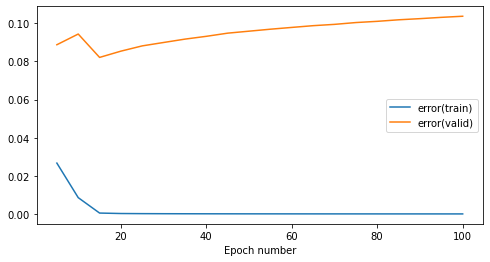

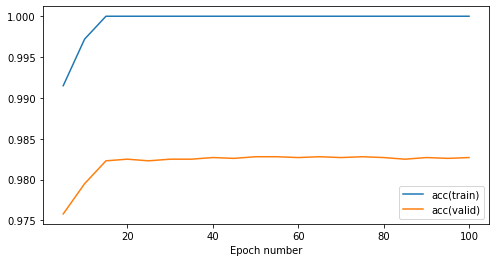

In [21]:
# Size of pools to take maximum over
pool_size = 2

input_dim, output_dim, hidden_dim = 784, 10, 100

# Use Glorot initialisation scheme for weights and zero biases
weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# Create three affine layer model interleaved with max-pooling layers
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim * pool_size, weights_init, biases_init),
    MaxPoolingLayer(pool_size),
    AffineLayer(hidden_dim, hidden_dim * pool_size, weights_init, biases_init),
    MaxPoolingLayer(pool_size),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

# Multiclass classification therefore use cross-entropy + softmax error
error = CrossEntropySoftmaxError()

# Use a momentum learning rule - you could use an adaptive learning rule
# implemented for the coursework here instead
learning_rule = MomentumLearningRule(0.02, 0.9)

# Monitor classification accuracy during training
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

num_epochs = 100
stats_interval = 5

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval,
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

# Plot the change in the validation and training set accuracy over training.
fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval,
              stats[1:, keys[k]], label=k)
ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')